Data Preprocessing/ EDA

1.   Understand data
2.   Data Distribution
3.   Creating Severity
3.   Correlation Analysis
4.   

In [649]:
# !pip install imbalanced-learn


In [650]:
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split



In [651]:
# from google.colab import drive
# drive.mount('/content/drive')

In [652]:
# df include both NonAP and AP ICD diagnosis (ARE ALL NONAP JUST DONT HAVE AN ICD_CODE?)
## MAYBE WE CAN USE MOST CORRELATED ICD_CODE TEHRE TO FIND COMORBIDILITY
df = pd.read_csv('AP_ICD_CCI_dataset.csv')

In [653]:
df.head()

,subject_id,hadm_id,charttime,lipase_level,admittime,dischtime,gender,approximate_age_at_admission,race,actual_age,...,chloride_chemistry,glucose_chemistry,sodium_chemistry,potassium_chemistry,bilirubin_total_enzyme,amylase_enzyme,alt_enzyme,alp_enzyme,ast_enzyme,creatinine_albumin_ratio
0,10004606,29242151,2159-02-20 18:30:00,1222.0,2159-02-20 13:43:00,2159-03-06 16:51:00,F,64,WHITE,64,...,110.0,144.0,143.0,4.5,1.7,302.0,523.0,252.0,333.0,0.250000
1,10006431,24638489,2129-01-23 23:36:00,508.0,2129-01-24 01:08:00,2129-01-30 16:50:00,F,66,WHITE,67,...,98.0,102.0,139.0,4.6,0.6,177.0,14.0,138.0,14.0,0.151515
2,10017531,22580355,2159-09-22 20:56:00,1164.0,2159-09-22 19:30:00,2159-10-24 13:40:00,M,63,WHITE,64,...,115.0,726.0,148.0,5.7,1.1,43.0,85.0,94.0,55.0,0.435897
3,10021357,25937617,2144-12-30 06:55:00,1249.0,2144-12-27 19:41:00,2145-01-04 19:54:00,F,91,WHITE,91,...,111.0,132.0,144.0,3.8,7.3,NaN,348.0,524.0,223.0,0.400000
4,10036086,28728587,2196-05-26 09:25:00,677.0,2196-05-20 02:47:00,2196-06-12 11:42:00,M,57,WHITE,58,...,112.0,371.0,150.0,5.8,5.6,231.0,257.0,719.0,303.0,2.000000


In [654]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2299 entries, 0 to 2298
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   subject_id                    2299 non-null   int64  
 1   hadm_id                       2299 non-null   int64  
 2   charttime                     2299 non-null   object 
 3   lipase_level                  2299 non-null   float64
 4   admittime                     2299 non-null   object 
 5   dischtime                     2299 non-null   object 
 6   gender                        2299 non-null   object 
 7   approximate_age_at_admission  2299 non-null   int64  
 8   race                          2299 non-null   object 
 9   actual_age                    2299 non-null   int64  
 10  in_hospital_death             2299 non-null   bool   
 11  length_of_stay                2299 non-null   float64
 12  is_confirmed_ap               2299 non-null   bool   
 13  cha

In [655]:
df[df[['lipase_level', 'amylase_enzyme']].notna().all(axis=1)]

,subject_id,hadm_id,charttime,lipase_level,admittime,dischtime,gender,approximate_age_at_admission,race,actual_age,...,chloride_chemistry,glucose_chemistry,sodium_chemistry,potassium_chemistry,bilirubin_total_enzyme,amylase_enzyme,alt_enzyme,alp_enzyme,ast_enzyme,creatinine_albumin_ratio
0,10004606,29242151,2159-02-20 18:30:00,1222.0,2159-02-20 13:43:00,2159-03-06 16:51:00,F,64,WHITE,64,...,110.0,144.0,143.0,4.5,1.7,302.0,523.0,252.0,333.0,0.250000
1,10006431,24638489,2129-01-23 23:36:00,508.0,2129-01-24 01:08:00,2129-01-30 16:50:00,F,66,WHITE,67,...,98.0,102.0,139.0,4.6,0.6,177.0,14.0,138.0,14.0,0.151515
2,10017531,22580355,2159-09-22 20:56:00,1164.0,2159-09-22 19:30:00,2159-10-24 13:40:00,M,63,WHITE,64,...,115.0,726.0,148.0,5.7,1.1,43.0,85.0,94.0,55.0,0.435897
4,10036086,28728587,2196-05-26 09:25:00,677.0,2196-05-20 02:47:00,2196-06-12 11:42:00,M,57,WHITE,58,...,112.0,371.0,150.0,5.8,5.6,231.0,257.0,719.0,303.0,2.000000
7,10049833,20762302,2168-05-24 17:37:00,692.0,2168-05-24 16:43:00,2168-05-30 12:05:00,M,32,WHITE,32,...,108.0,129.0,142.0,4.3,0.8,285.0,91.0,69.0,149.0,0.366667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2294,19970491,22119205,2131-02-11 03:06:00,487.0,2131-02-10 18:25:00,2131-02-17 14:15:00,M,55,WHITE,57,...,106.0,144.0,142.0,6.5,3.8,629.0,187.0,657.0,259.0,0.457143
2295,19977727,23685838,2170-06-12 07:20:00,528.0,2170-06-10 22:54:00,2170-06-12 14:37:00,F,64,WHITE,64,...,111.0,93.0,142.0,4.2,0.6,222.0,109.0,93.0,158.0,NaN
2296,19990545,23106222,2139-10-06 08:30:00,1886.0,2139-10-04 23:11:00,2139-10-29 15:45:00,F,43,ASIAN - ASIAN INDIAN,43,...,102.0,224.0,138.0,4.8,4.0,910.0,223.0,299.0,394.0,0.307692
2297,19996968,29843339,2125-01-23 06:25:00,508.0,2125-01-20 21:17:00,2125-01-23 14:42:00,M,32,BLACK/AFRICAN AMERICAN,32,...,101.0,110.0,141.0,3.9,0.6,144.0,67.0,61.0,64.0,0.194444


In [656]:
df[df['subject_id'].duplicated(keep=False)].head()

,subject_id,hadm_id,charttime,lipase_level,admittime,dischtime,gender,approximate_age_at_admission,race,actual_age,...,chloride_chemistry,glucose_chemistry,sodium_chemistry,potassium_chemistry,bilirubin_total_enzyme,amylase_enzyme,alt_enzyme,alp_enzyme,ast_enzyme,creatinine_albumin_ratio
12,10074556,20846673,2126-02-06 05:35:00,517.0,2126-01-30 18:56:00,2126-02-24 11:30:00,M,41,WHITE,46,...,113.0,2172.0,150.0,5.2,1.7,366.0,345.0,244.0,194.0,0.361111
13,10074556,24544038,2121-01-12 07:35:00,550.0,2121-01-11 13:40:00,2121-01-13 16:44:00,M,41,WHITE,41,...,102.0,96.0,138.0,4.3,2.3,310.0,21.0,68.0,25.0,NaN
29,10149959,20738420,2144-01-17 07:40:00,652.0,2144-01-16 10:36:00,2144-01-23 13:50:00,F,73,WHITE,73,...,108.0,109.0,144.0,4.4,0.6,877.0,75.0,83.0,50.0,NaN
30,10149959,24022109,2144-11-27 21:20:00,2077.0,2144-11-28 01:00:00,2144-12-07 12:58:00,F,73,WHITE,73,...,106.0,172.0,141.0,4.2,0.4,1056.0,10.0,75.0,23.0,0.310345
35,10164170,21635159,2163-06-06 15:40:00,2354.0,2163-06-01 03:27:00,2163-06-12 16:00:00,F,87,WHITE - OTHER EUROPEAN,87,...,103.0,316.0,138.0,5.6,0.5,NaN,20.0,67.0,39.0,0.695652


In [657]:
duplicate_entries = df.groupby(['subject_id', 'admittime']).size().reset_index(name='count')

# Filter for patient with more than one occurrence for each admit
duplicates = duplicate_entries[duplicate_entries['count'] > 1]

# Display the duplicates, if any
if not duplicates.empty:
    print("Found duplicate entries with the same subject_id and admittime:")
    print(duplicates)
else:
    print("No duplicate entries found with the same subject_id and admittime.")


No duplicate entries found with the same subject_id and admittime.


In [658]:
count_true_is_ap = df['is_confirmed_ap'].sum()
print(f"Number of patients with Confirmed_AP from ICD is: {count_true_is_ap}")

Number of patients with Confirmed_AP from ICD is: 1494


In [659]:
df.describe()

,subject_id,hadm_id,lipase_level,approximate_age_at_admission,actual_age,length_of_stay,charlson_comorbidity_index,albumin_chemistry,creatinine_chemistry,aniongap_chemistry,...,chloride_chemistry,glucose_chemistry,sodium_chemistry,potassium_chemistry,bilirubin_total_enzyme,amylase_enzyme,alt_enzyme,alp_enzyme,ast_enzyme,creatinine_albumin_ratio
count,2.299000e+03,2.299000e+03,2299.000000,2299.000000,2299.000000,2299.000000,2299.000000,1681.000000,2286.000000,2284.000000,...,2285.000000,2286.000000,2285.000000,2285.000000,2231.000000,1333.000000,2240.000000,2238.000000,2244.000000,1681.000000
mean,1.499232e+07,2.504691e+07,2512.614180,57.928230,59.176599,11.247982,2.599826,3.552231,1.952056,18.401926,...,107.673961,201.079178,142.449891,4.704858,3.935814,586.382596,312.887054,227.521001,513.990196,0.656770
std,2.894608e+06,2.854976e+06,23177.129645,17.781298,17.739071,15.030780,1.717143,0.649512,2.267883,5.564382,...,5.808160,209.976084,4.774032,0.903553,6.906079,617.630459,903.815053,243.064924,1893.237819,0.779546
min,1.000461e+07,2.000264e+07,420.000000,18.000000,18.000000,0.117361,0.000000,1.600000,0.400000,9.000000,...,81.000000,53.000000,117.000000,3.000000,0.100000,7.000000,5.000000,23.000000,9.000000,0.076923
25%,1.249474e+07,2.261493e+07,571.000000,45.000000,47.000000,3.489931,1.000000,3.100000,0.800000,15.000000,...,104.000000,116.000000,140.000000,4.100000,0.600000,222.000000,34.000000,90.000000,41.000000,0.222222
50%,1.500406e+07,2.505687e+07,871.000000,58.000000,59.000000,5.920833,3.000000,3.600000,1.000000,17.000000,...,107.000000,149.000000,142.000000,4.500000,1.400000,386.000000,95.000000,145.000000,106.000000,0.333333
75%,1.752683e+07,2.753959e+07,1634.000000,72.000000,73.000000,13.100694,4.000000,4.000000,1.900000,20.000000,...,111.000000,216.750000,144.000000,5.100000,4.100000,737.000000,262.250000,265.750000,253.000000,0.722222
max,1.999888e+07,2.999193e+07,999999.000000,91.000000,97.000000,219.908333,7.000000,6.600000,20.100000,55.000000,...,139.000000,3600.000000,175.000000,10.700000,72.000000,4801.000000,11630.000000,2802.000000,27290.000000,6.700000


# Understanding Data

**CATEGORICAL: gender/ race/ in_hospital_death**

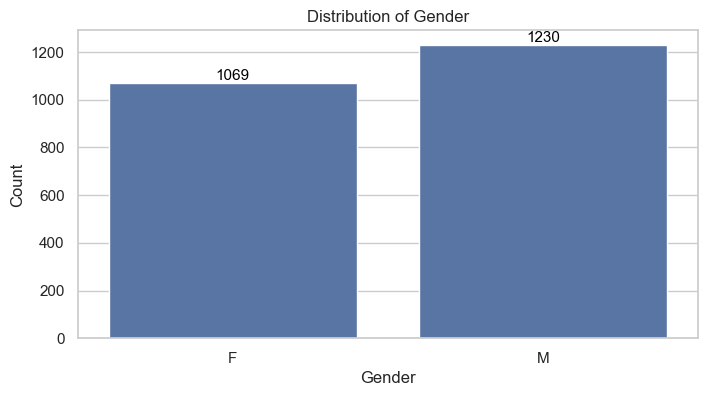

In [660]:
sns.set(style="whitegrid")

# Creating a count plot for gender
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='gender', data=df)
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')
plt.show()


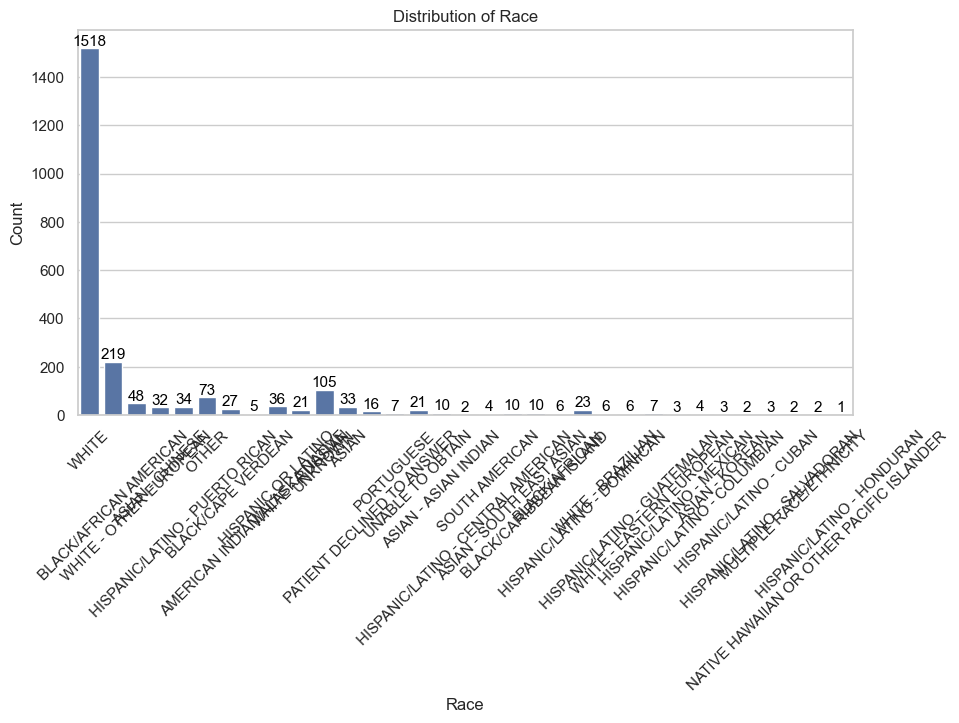

In [661]:
# Creating a count plot for race
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='race', data=df)
plt.title('Distribution of Race')
plt.xlabel('Race')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Useful if there are many categories or long names
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')
plt.show()

## very biased towards race WHITE
## Were all patients associated with one race?

In [662]:
len(df[df['race'] == "WHITE"])

1518

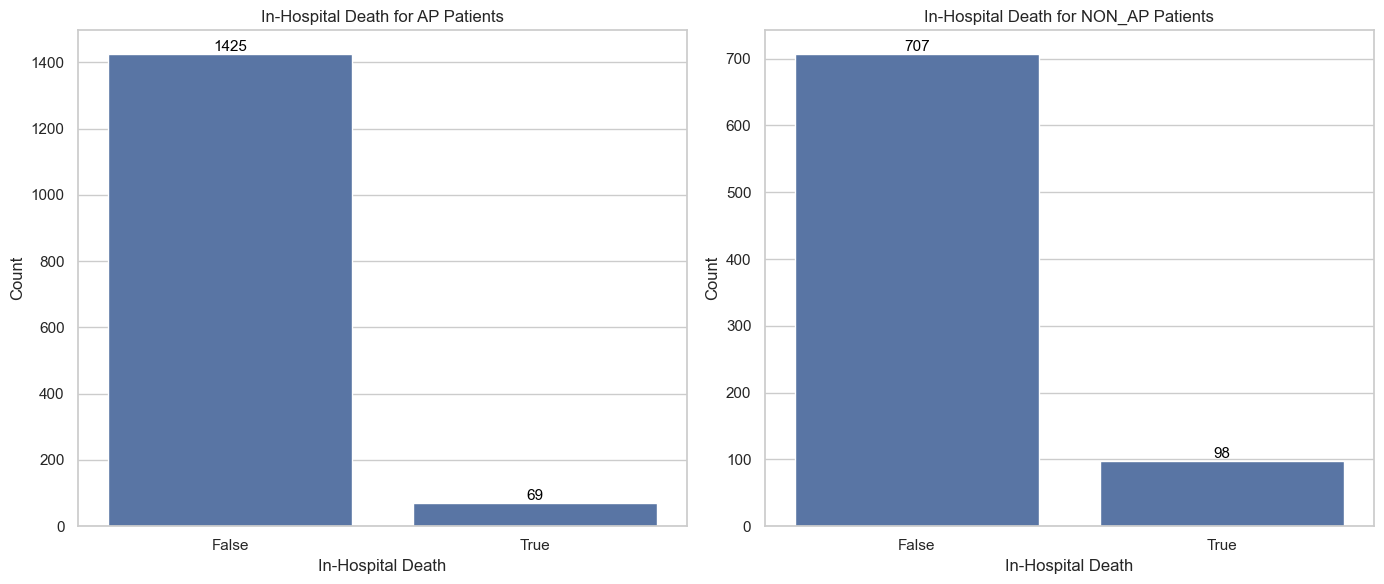

In [663]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

# First plot: Distribution of in-hospital death for patients with AP
plt.subplot(1, 2, 1)
ax1 = sns.countplot(x='in_hospital_death', data=df[df['is_confirmed_ap'] == True])
plt.title('In-Hospital Death for AP Patients')
plt.xlabel('In-Hospital Death')
plt.ylabel('Count')
# Annotate bars
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')

# Second plot: Distribution of in-hospital death for patients with NOT_AP
plt.subplot(1, 2, 2)
ax2 = sns.countplot(x='in_hospital_death', data=df[df['is_confirmed_ap'] == False])
plt.title('In-Hospital Death for NON_AP Patients')
plt.xlabel('In-Hospital Death')
plt.ylabel('Count')
# Annotate bars
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')

# Show the plots
plt.tight_layout()
plt.show()


**NUMERICAL**
1. length of stay
2. length of stay for AP in_hosp_death or not_death
3. level of lipase

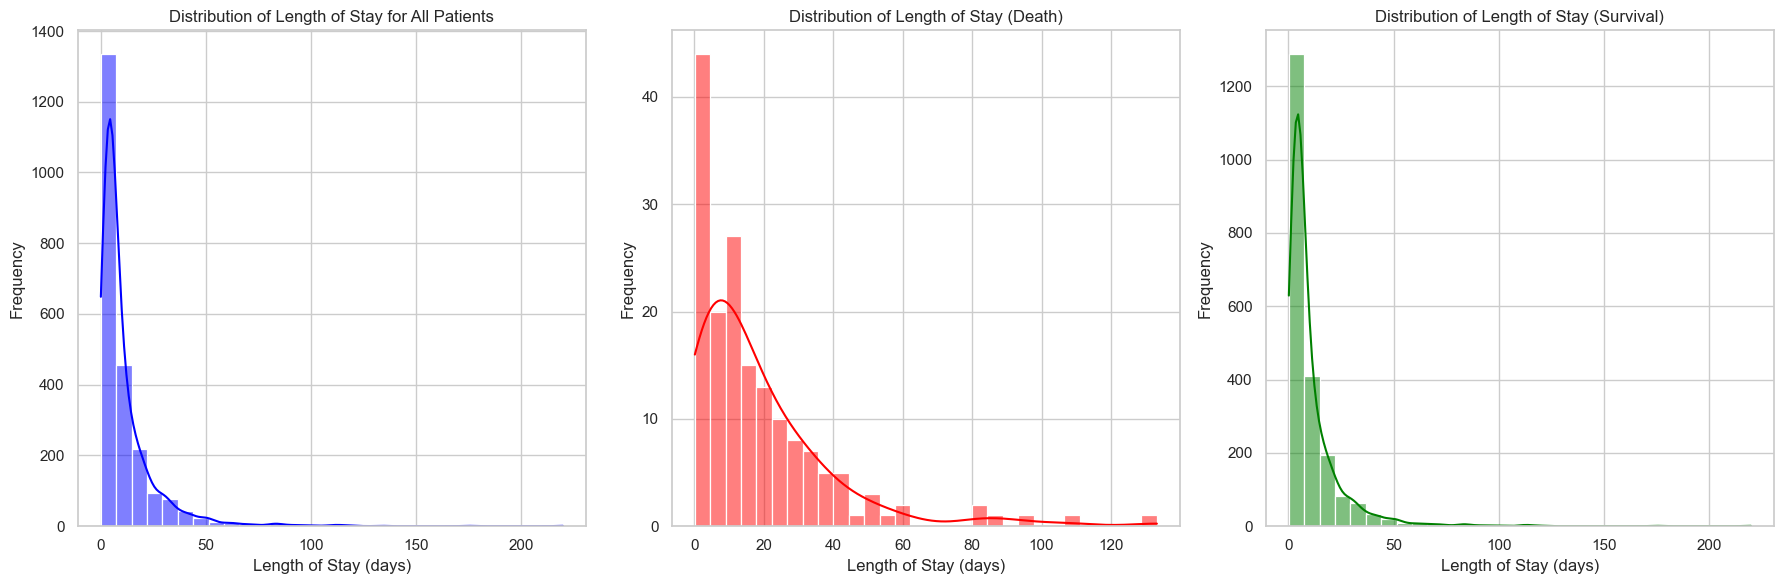

In [664]:
plt.figure(figsize=(18, 6))

# Histogram for the entire dataset
plt.subplot(1, 3, 1)
sns.histplot(df['length_of_stay'], bins=30, kde=True, color='blue')
plt.title('Distribution of Length of Stay for All Patients')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')

# Histogram for patients where in_hospital_death is True
plt.subplot(1, 3, 2)
sns.histplot(df[df['in_hospital_death'] == True]['length_of_stay'], bins=30, kde=True, color='red')
plt.title('Distribution of Length of Stay (Death)')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')

# Histogram for patients where in_hospital_death is False
plt.subplot(1, 3, 3)
sns.histplot(df[df['in_hospital_death'] == False]['length_of_stay'], bins=30, kde=True, color='green')
plt.title('Distribution of Length of Stay (Survival)')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



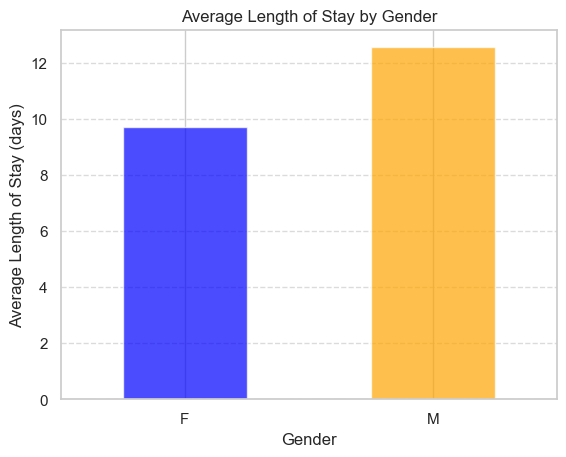

In [665]:
# Relationship between Length of Stay with Gender
average_los_by_gender = df.groupby('gender')['length_of_stay'].mean()

# Bar plot of average length of stay by gender
average_los_by_gender.plot(kind='bar', color=['blue', 'orange'], alpha=0.7)
plt.title('Average Length of Stay by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Length of Stay (days)')
plt.xticks(rotation=0)  # Rotate labels to horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


1. Short Stays Predominate: In all groups, there's a clear concentration of cases with short hospital stays. This is typical in many healthcare settings where the goal is to minimize hospital stay without compromising patient care.
2. Differences in Length of Stay Distribution: The fact that deceased patients generally have shorter stays could be indicative of severe cases that unfortunately result in rapid deterioration, or it could reflect terminal cases admitted for end-of-life care.
3. Survivors with Extended Stays: The heavier tail in the survivors' histogram suggests some patients might have longer recovery periods, possibly due to complications, more extensive treatments, or slower recovery processes.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2299 entries, 0 to 2298
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   actual_age      2299 non-null   int64  
 1   length_of_stay  2299 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 36.1 KB
None
actual_age        0
length_of_stay    0
dtype: int64


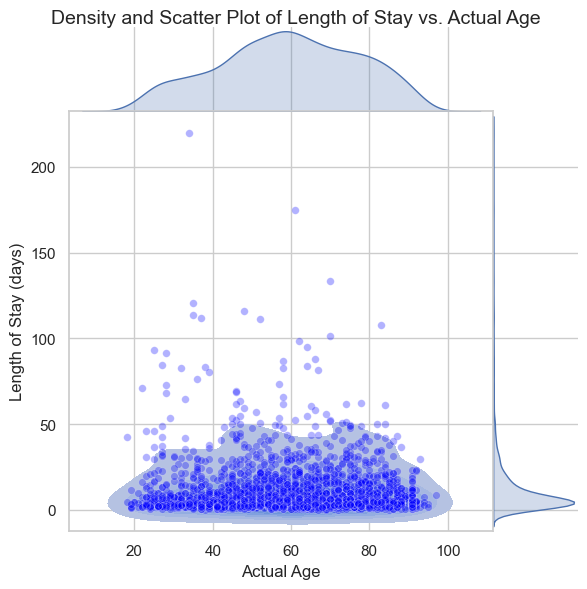

In [666]:
# Check data types and look for any NaN values
print(df[['actual_age', 'length_of_stay']].info())
print(df[['actual_age', 'length_of_stay']].isna().sum())

# If necessary, drop rows with NaN values in these columns
df_clean1 = df.dropna(subset=['actual_age', 'length_of_stay'])

# Retry the density and scatter plot
sns.set(style="whitegrid")
g = sns.jointplot(x='actual_age', y='length_of_stay', data=df_clean1, kind="kde", fill=True, space=0)
g.plot_joint(sns.scatterplot, s=30, alpha=0.3, color='blue')
g.set_axis_labels('Actual Age', 'Length of Stay (days)', fontsize=12)
g.fig.suptitle('Density and Scatter Plot of Length of Stay vs. Actual Age', fontsize=14)
g.fig.subplots_adjust(top=0.95)  # Adjust the title to not overlap with plots
plt.show()


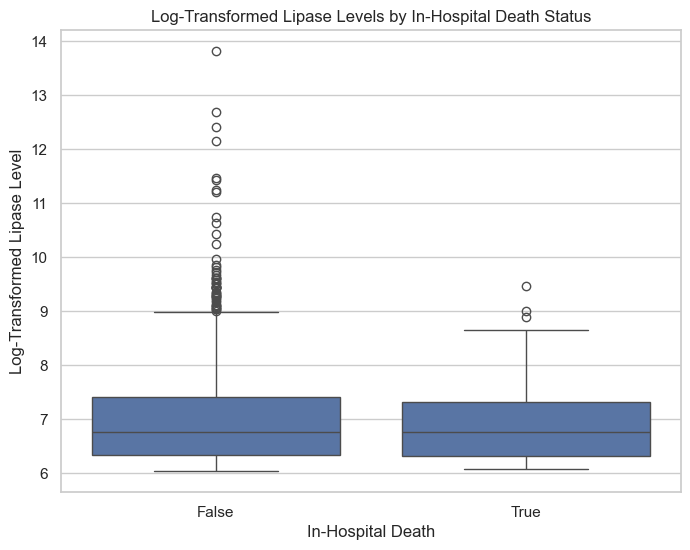

In [667]:
import numpy as np

plt.figure(figsize=(8, 6))
# Apply a log transformation to the lipase levels
sns.boxplot(x='in_hospital_death', y=np.log1p(df['lipase_level']), data=df)  # log1p is used to handle zero values
plt.title('Log-Transformed Lipase Levels by In-Hospital Death Status')
plt.xlabel('In-Hospital Death')
plt.ylabel('Log-Transformed Lipase Level')
plt.show()



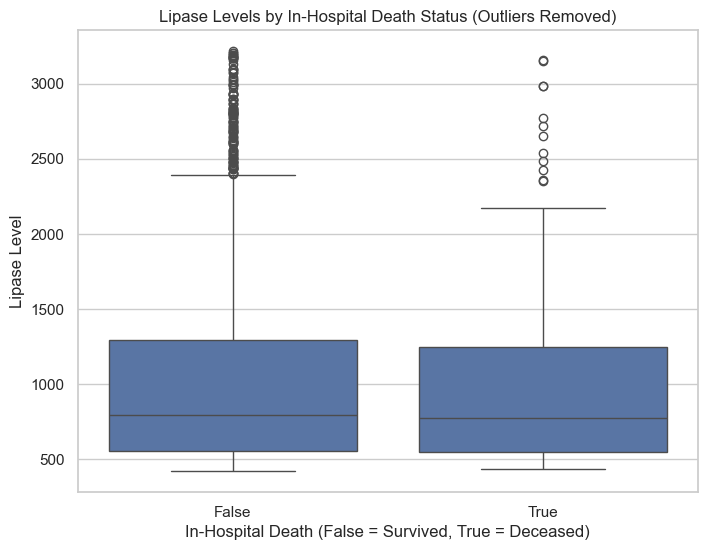

In [668]:
# Calculate IQR
Q1 = df['lipase_level'].quantile(0.25)
Q3 = df['lipase_level'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter data to exclude outliers
filtered_df = df[(df['lipase_level'] > lower_bound) & (df['lipase_level'] < upper_bound)]

# Plotting without outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x='in_hospital_death', y='lipase_level', data=filtered_df)
plt.title('Lipase Levels by In-Hospital Death Status (Outliers Removed)')
plt.xlabel('In-Hospital Death (False = Survived, True = Deceased)')
plt.ylabel('Lipase Level')
plt.show()

In [669]:
from scipy.stats import mannwhitneyu

# Filter the data for the two groups
group_dead = df[df['in_hospital_death'] == 1]['length_of_stay']
group_survived = df[df['in_hospital_death'] == 0]['length_of_stay']

# Perform the Mann-Whitney U Test
stat, p = mannwhitneyu(group_dead, group_survived)

print(f'Statistics={stat}, p-value={p}')
if p < 0.05:
    print("The difference in length of stay between groups is statistically significant.")
else:
    print("No significant difference in length of stay between groups.")

Statistics=221557.0, p-value=1.3644334433905093e-07
The difference in length of stay between groups is statistically significant.


# Creating Severity

In [670]:
import pandas as pd

def categorize_severity(df):
    deceased_df = df[df['in_hospital_death'] == True]
    deceased_df['severity'] = 'death'

    # Remove deceased patients from the main DataFrame
    non_deceased_df = df[df['in_hospital_death'] == False]

    # Define the bins and labels for severity
    bins = [0, 1.5, 6.9, 14.2, float('inf')]
    labels = ['mild', 'moderate', 'severe', 'critical']


    non_deceased_df['severity'] = pd.cut(non_deceased_df['length_of_stay'], bins=bins, labels=labels, right=False)
    final_df = pd.concat([non_deceased_df, deceased_df], ignore_index=True)

    return final_df


In [671]:
df2 = categorize_severity(df)

/var/folders/5w/c5jgggvd3f52shk667p25scc0000gn/T/ipykernel_62097/73191689.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deceased_df['severity'] = 'death'
/var/folders/5w/c5jgggvd3f52shk667p25scc0000gn/T/ipykernel_62097/73191689.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_deceased_df['severity'] = pd.cut(non_deceased_df['length_of_stay'], bins=bins, labels=labels, right=False)


In [672]:
df2

,subject_id,hadm_id,charttime,lipase_level,admittime,dischtime,gender,approximate_age_at_admission,race,actual_age,...,glucose_chemistry,sodium_chemistry,potassium_chemistry,bilirubin_total_enzyme,amylase_enzyme,alt_enzyme,alp_enzyme,ast_enzyme,creatinine_albumin_ratio,severity
0,10004606,29242151,2159-02-20 18:30:00,1222.0,2159-02-20 13:43:00,2159-03-06 16:51:00,F,64,WHITE,64,...,144.0,143.0,4.5,1.7,302.0,523.0,252.0,333.0,0.250000,severe
1,10006431,24638489,2129-01-23 23:36:00,508.0,2129-01-24 01:08:00,2129-01-30 16:50:00,F,66,WHITE,67,...,102.0,139.0,4.6,0.6,177.0,14.0,138.0,14.0,0.151515,moderate
2,10017531,22580355,2159-09-22 20:56:00,1164.0,2159-09-22 19:30:00,2159-10-24 13:40:00,M,63,WHITE,64,...,726.0,148.0,5.7,1.1,43.0,85.0,94.0,55.0,0.435897,critical
3,10021357,25937617,2144-12-30 06:55:00,1249.0,2144-12-27 19:41:00,2145-01-04 19:54:00,F,91,WHITE,91,...,132.0,144.0,3.8,7.3,NaN,348.0,524.0,223.0,0.400000,severe
4,10036086,28728587,2196-05-26 09:25:00,677.0,2196-05-20 02:47:00,2196-06-12 11:42:00,M,57,WHITE,58,...,371.0,150.0,5.8,5.6,231.0,257.0,719.0,303.0,2.000000,critical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2294,19651093,26488509,2192-03-19 15:00:00,546.0,2192-03-17 21:05:00,2192-07-03 19:08:00,M,74,WHITE,83,...,2245.0,154.0,7.1,4.3,4512.0,402.0,503.0,1056.0,1.724138,death
2295,19669999,28614555,2148-08-09 23:40:00,2066.0,2148-08-10 02:24:00,2148-08-10 13:55:00,F,84,OTHER,89,...,105.0,139.0,6.9,0.3,NaN,129.0,246.0,464.0,0.800000,death
2296,19676211,27134485,2134-05-15 05:26:00,980.0,2134-04-22 20:37:00,2134-05-21 18:57:00,F,79,WHITE,79,...,186.0,145.0,6.1,0.6,NaN,NaN,88.0,15.0,2.080000,death
2297,19699086,24464855,2122-06-05 09:04:00,501.0,2122-06-05 03:09:00,2122-06-05 10:20:00,M,67,WHITE,67,...,204.0,143.0,4.7,1.1,374.0,239.0,342.0,385.0,1.277778,death


/var/folders/5w/c5jgggvd3f52shk667p25scc0000gn/T/ipykernel_62097/4071255639.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='severity', data=df, order=['mild', 'moderate', 'severe', 'critical', 'death'], palette='viridis')


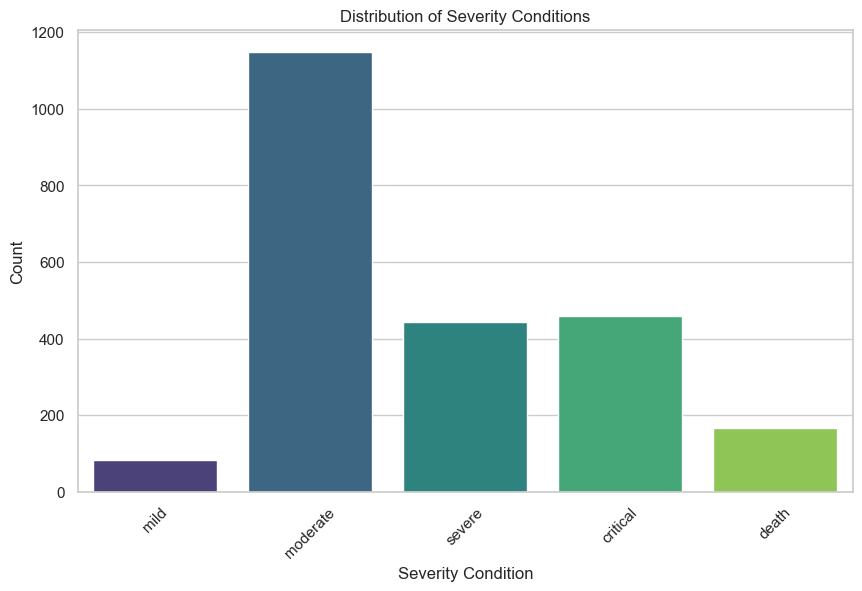

In [673]:
def plot_severity_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(x='severity', data=df, order=['mild', 'moderate', 'severe', 'critical', 'death'], palette='viridis')
    plt.title('Distribution of Severity Conditions')
    plt.xlabel('Severity Condition')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# Assuming 'df_with_severity' is your DataFrame after applying the 'categorize_severity' function
plot_severity_distribution(df2)


In [674]:
# Define the threshold for allowed NaN percentage
threshold = 50  # 50% of data missing

# Calculate the percentage of NaNs for each column
percentage_nans = df2.isna().mean() * 100

# Filter out columns exceeding the threshold
columns_to_drop = percentage_nans[percentage_nans > threshold].index

# Drop these columns from the DataFrame
df_cleaned = df2.drop(columns=columns_to_drop)

# Dropping the 'icd_code' and 'approximate_age_at_admission' columns from the cleaned DataFrame
df_cleaned = df_cleaned.drop(columns=['icd_code', 'approximate_age_at_admission'], errors='ignore')


In [675]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2299 entries, 0 to 2298
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   subject_id                  2299 non-null   int64  
 1   hadm_id                     2299 non-null   int64  
 2   charttime                   2299 non-null   object 
 3   lipase_level                2299 non-null   float64
 4   admittime                   2299 non-null   object 
 5   dischtime                   2299 non-null   object 
 6   gender                      2299 non-null   object 
 7   race                        2299 non-null   object 
 8   actual_age                  2299 non-null   int64  
 9   in_hospital_death           2299 non-null   bool   
 10  length_of_stay              2299 non-null   float64
 11  is_confirmed_ap             2299 non-null   bool   
 12  charlson_comorbidity_index  2299 non-null   int64  
 13  albumin_chemistry           1681 

In [676]:
# Select rows without any NaN values in the cleaned DataFrame
rows_with_no_nan = df_cleaned.dropna()

rows_with_no_nan.info()

### CANT DROP NAN, OTHERWISE ONLY 437 ROWS REMAINED

<class 'pandas.core.frame.DataFrame'>
Index: 1024 entries, 0 to 2298
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   subject_id                  1024 non-null   int64  
 1   hadm_id                     1024 non-null   int64  
 2   charttime                   1024 non-null   object 
 3   lipase_level                1024 non-null   float64
 4   admittime                   1024 non-null   object 
 5   dischtime                   1024 non-null   object 
 6   gender                      1024 non-null   object 
 7   race                        1024 non-null   object 
 8   actual_age                  1024 non-null   int64  
 9   in_hospital_death           1024 non-null   bool   
 10  length_of_stay              1024 non-null   float64
 11  is_confirmed_ap             1024 non-null   bool   
 12  charlson_comorbidity_index  1024 non-null   int64  
 13  albumin_chemistry           1024 non-n

/var/folders/5w/c5jgggvd3f52shk667p25scc0000gn/T/ipykernel_62097/4071255639.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='severity', data=df, order=['mild', 'moderate', 'severe', 'critical', 'death'], palette='viridis')


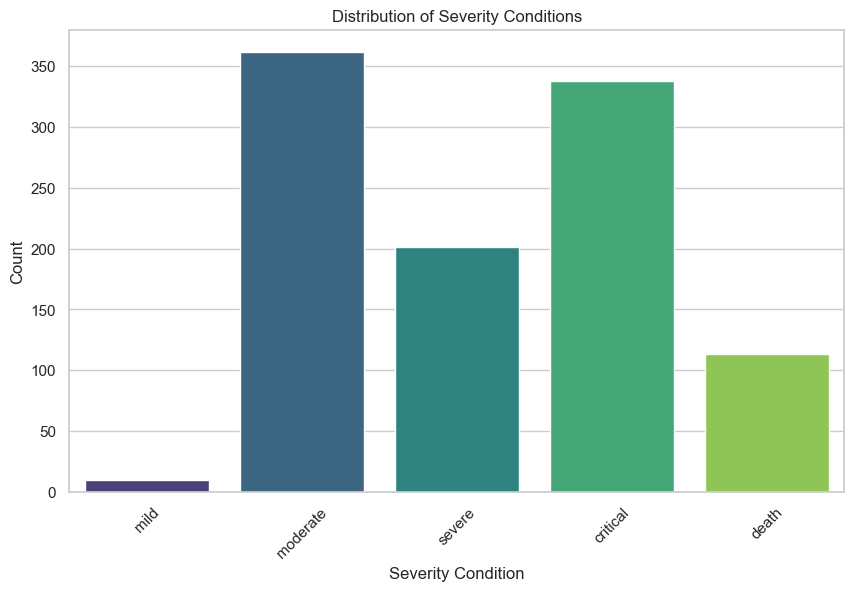

In [677]:
plot_severity_distribution(rows_with_no_nan)

In [678]:
## not many mild left
## 还有种办法 就保留lipase和amylase原数据， 剩下的都手动填original dataset的mean

In [679]:
df_cleaned.groupby('severity')['lipase_level'].describe()

,count,mean,std,min,25%,50%,75%,max
severity,,,,,,,,
critical,459.0,4056.886710,47663.417441,420.0,529.00,713.0,1278.00,999999.0
death,167.0,1373.485030,1536.912508,435.0,554.50,869.0,1510.50,12910.0
mild,82.0,1381.256098,1774.679632,437.0,540.00,738.0,1489.25,13595.0
moderate,1149.0,1879.006963,3464.784918,420.0,605.00,961.0,1887.00,76700.0
severe,442.0,3196.323529,20058.886070,420.0,575.75,859.5,1574.75,322000.0


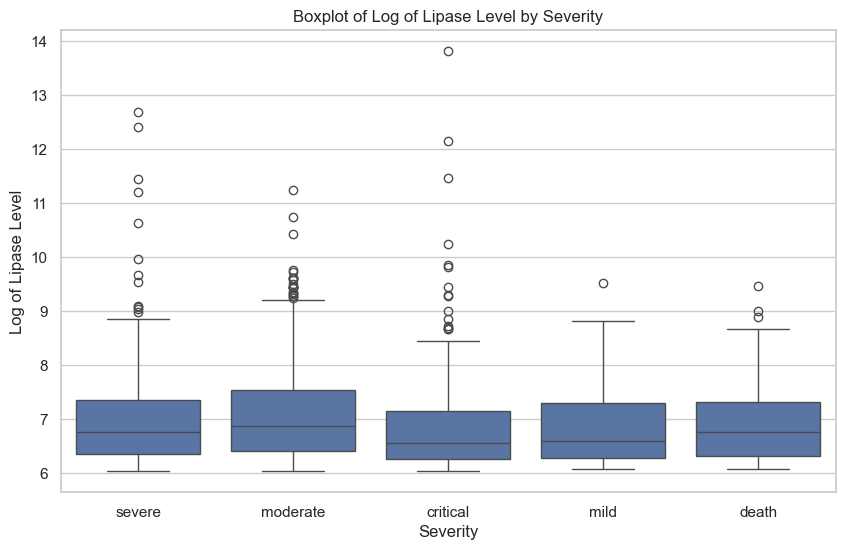

In [680]:
# Assuming 'df_cleaned' has a 'severity' column and 'lipase_level' column
# Calculate the logarithm of the lipase_level to reduce skewness in the data
df_cleaned['log_lipase_level'] = np.log(df_cleaned['lipase_level'])

# Creating a boxplot with the log of lipase level
plt.figure(figsize=(10, 6))
sns.boxplot(x='severity', y='log_lipase_level', data=df_cleaned)

plt.title('Boxplot of Log of Lipase Level by Severity')
plt.xlabel('Severity')
plt.ylabel('Log of Lipase Level')
plt.show()


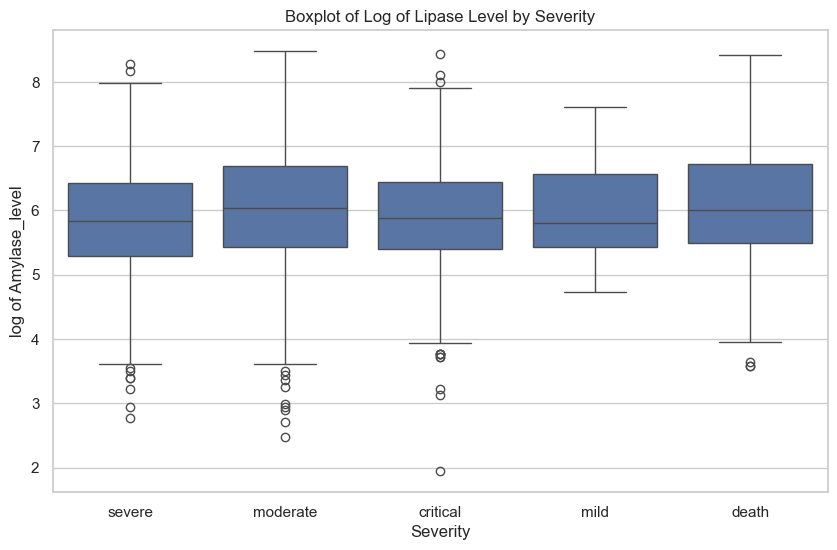

In [681]:
df_cleaned['log_amylase_level'] = np.log(df_cleaned['amylase_enzyme'])
plt.figure(figsize=(10, 6))
sns.boxplot(x='severity', y='log_amylase_level', data=df_cleaned)

plt.title('Boxplot of Log of Lipase Level by Severity')
plt.xlabel('Severity')
plt.ylabel('log of Amylase_level')
plt.show()

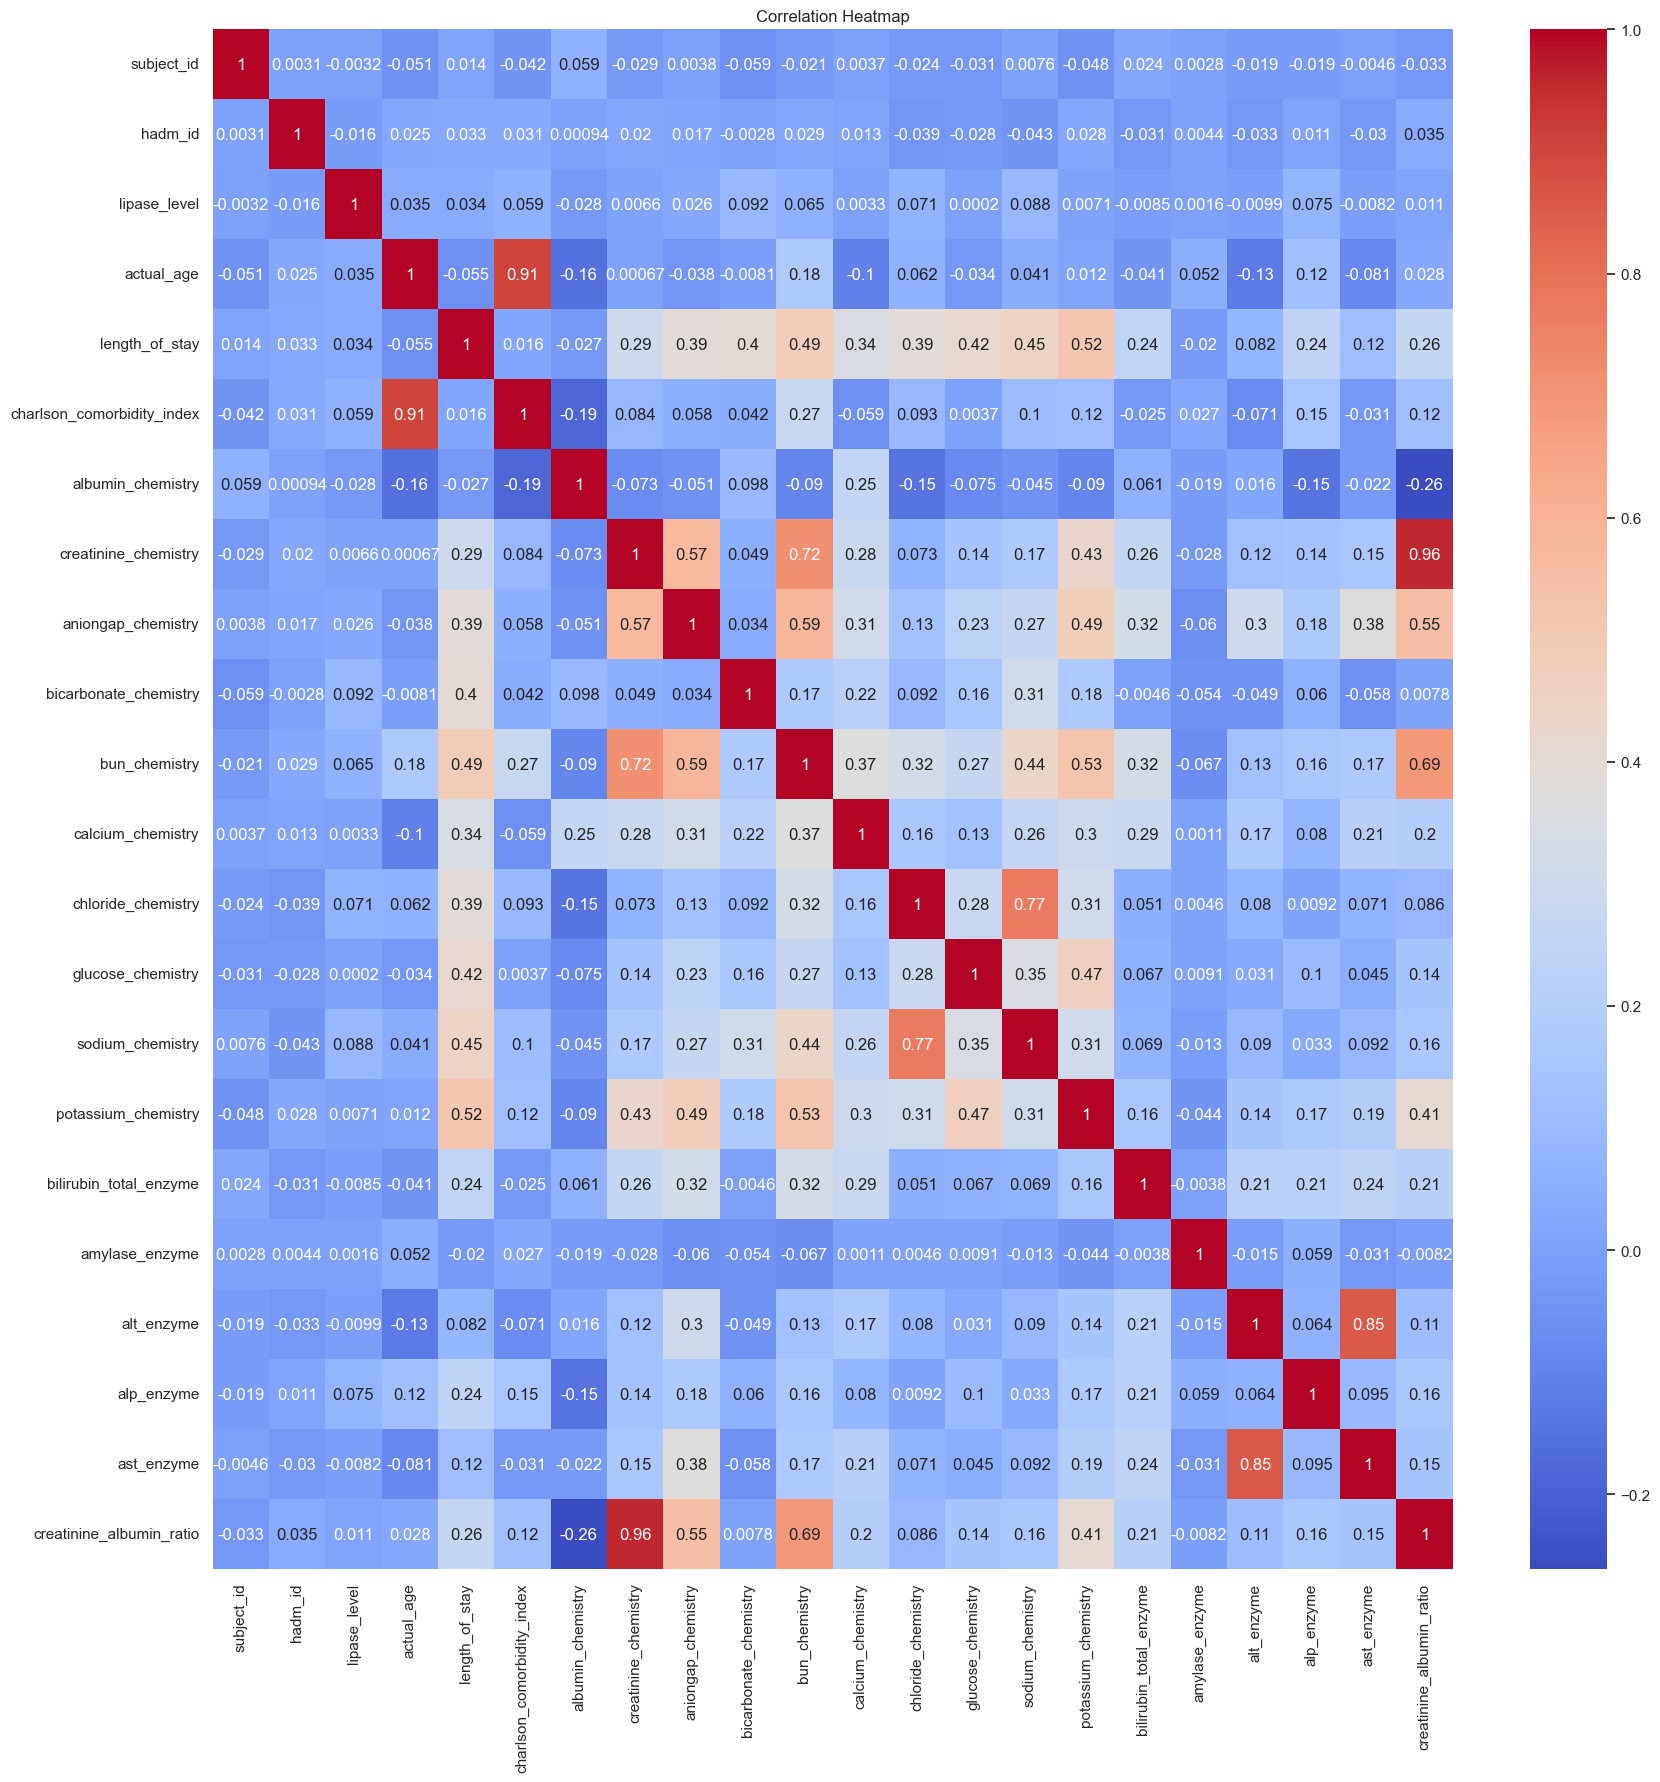

In [682]:
# Feature correlation
numeric_df = rows_with_no_nan.select_dtypes(include=[float, int])

# Handle any remaining missing values in numeric_df by filling them with median values
numeric_df = numeric_df.fillna(numeric_df.median())

# Generate a heatmap of the correlation matrix for the numeric columns
plt.figure(figsize=(20, 20))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [683]:
# Import necessary libraries
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Selecting numeric columns only for VIF calculation
numeric_df = rows_with_no_nan.select_dtypes(include=[float, int])

# Standardize numeric features before calculating VIF to improve numerical stability
scaler = StandardScaler()
scaled_numeric_df = pd.DataFrame(scaler.fit_transform(numeric_df), columns=numeric_df.columns)
print(scaled_numeric_df.isna().sum())

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = scaled_numeric_df.columns
vif_data["VIF"] = [variance_inflation_factor(scaled_numeric_df.values, i) for i in range(scaled_numeric_df.shape[1])]

# Display VIF values
print(vif_data)


subject_id                    0
hadm_id                       0
lipase_level                  0
actual_age                    0
length_of_stay                0
charlson_comorbidity_index    0
albumin_chemistry             0
creatinine_chemistry          0
aniongap_chemistry            0
bicarbonate_chemistry         0
bun_chemistry                 0
calcium_chemistry             0
chloride_chemistry            0
glucose_chemistry             0
sodium_chemistry              0
potassium_chemistry           0
bilirubin_total_enzyme        0
amylase_enzyme                0
alt_enzyme                    0
alp_enzyme                    0
ast_enzyme                    0
creatinine_albumin_ratio      0
dtype: int64
                       feature        VIF
0                   subject_id   1.024124
1                      hadm_id   1.019783
2                 lipase_level   1.029805
3                   actual_age   6.213605
4               length_of_stay   2.144047
5   charlson_comorbidity_index 

**Classification**

In [684]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np

# Drop unnecessary columns (dates and IDs) for modeling purposes
df_clean = rows_with_no_nan.drop(columns=['subject_id', 'hadm_id', 'charttime', 'admittime', 'dischtime',
                            'in_hospital_death', 'race','length_of_stay'])

# df_clean = rows_with_no_nan.drop(columns=['subject_id', 'hadm_id', 'charttime', 'admittime', 'dischtime',
#                             'in_hospital_death', 'race','length_of_stay','first_charttime_chemistry', 'first_charttime_enzyme'])
# df_clean = df_clean_new

df_clean['gender'] = df_clean['gender'].map({'F': 0, 'M': 1})

# Encode 'severity' (target variable) as numerical
label_encoder = LabelEncoder()
df_clean['severity'] = label_encoder.fit_transform(df_clean['severity'])
print(df_clean.head())


   lipase_level  gender  actual_age  is_confirmed_ap  \
0        1222.0       0          64             True   
1         508.0       0          67             True   
2        1164.0       1          64             True   
4         677.0       1          58             True   
7         692.0       1          32             True   

   charlson_comorbidity_index  albumin_chemistry  creatinine_chemistry  \
0                           4                3.6                   0.9   
1                           3                3.3                   0.5   
2                           4                3.9                   1.7   
4                           2                3.3                   6.6   
7                           0                3.0                   1.1   

   aniongap_chemistry  bicarbonate_chemistry  bun_chemistry  ...  \
0                20.0                   28.0           11.0  ...   
1                17.0                   27.0            9.0  ...   
2             

In [685]:
# Convert boolean columns to integers (0 and 1)
bool_columns = df_clean.select_dtypes(include='bool').columns
df_clean[bool_columns] = df_clean[bool_columns].astype(int)

# Split dataset into features (X) and target (y)
X = df_clean.drop(columns=['severity'])
y = df_clean['severity']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features for better model performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [686]:
model = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=15)

model.fit(X_train, y_train)


y_pred = model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.697560975609756
Classification Report:
               precision    recall  f1-score   support

    critical       0.67      0.86      0.75        69
       death       0.90      0.41      0.56        22
        mild       0.00      0.00      0.00         3
    moderate       0.76      0.89      0.82        74
      severe       0.45      0.24      0.32        37

    accuracy                           0.70       205
   macro avg       0.56      0.48      0.49       205
weighted avg       0.68      0.70      0.67       205

Confusion Matrix:
 [[59  1  0  2  7]
 [13  9  0  0  0]
 [ 0  0  0  3  0]
 [ 4  0  0 66  4]
 [12  0  0 16  9]]


/Users/zhuyu/anaconda3/envs/COMP90089/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/zhuyu/anaconda3/envs/COMP90089/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/zhuyu/anaconda3/envs/COMP90089/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [687]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, n_estimators=200, max_depth=15, learning_rate=0.1)


model.fit(X_train, y_train)


y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


print(classification_report(y_test, y_pred))

/Users/zhuyu/anaconda3/envs/COMP90089/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:49:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.67
              precision    recall  f1-score   support

           0       0.68      0.78      0.72        69
           1       0.79      0.50      0.61        22
           2       0.00      0.00      0.00         3
           3       0.76      0.85      0.80        74
           4       0.36      0.27      0.31        37

    accuracy                           0.67       205
   macro avg       0.52      0.48      0.49       205
weighted avg       0.65      0.67      0.65       205



/Users/zhuyu/anaconda3/envs/COMP90089/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/zhuyu/anaconda3/envs/COMP90089/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/zhuyu/anaconda3/envs/COMP90089/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [688]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)


model.fit(X_train, y_train)


y_pred = model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.53


In [689]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report




model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))


Accuracy: 0.64
              precision    recall  f1-score   support

           0       0.70      0.77      0.73        69
           1       0.55      0.27      0.36        22
           2       0.00      0.00      0.00         3
           3       0.68      0.89      0.77        74
           4       0.29      0.16      0.21        37

    accuracy                           0.64       205
   macro avg       0.44      0.42      0.41       205
weighted avg       0.59      0.64      0.60       205



/Users/zhuyu/anaconda3/envs/COMP90089/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/zhuyu/anaconda3/envs/COMP90089/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/zhuyu/anaconda3/envs/COMP90089/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [690]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Convert target variable to one-hot encoded format
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

# Build a DNN model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_encoded, epochs=100, batch_size=10, validation_split=0.2)

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy and display the classification report
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred_classes))


Epoch 1/100


/Users/zhuyu/anaconda3/envs/COMP90089/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3383 - loss: 1.5378 - val_accuracy: 0.5488 - val_loss: 1.2164
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - accuracy: 0.5883 - loss: 1.0947 - val_accuracy: 0.5549 - val_loss: 1.1077
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - accuracy: 0.6116 - loss: 0.9385 - val_accuracy: 0.5671 - val_loss: 1.0834
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - accuracy: 0.6336 - loss: 0.9262 - val_accuracy: 0.5427 - val_loss: 1.0504
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - accuracy: 0.6485 - loss: 0.8520 - val_accuracy: 0.5854 - val_loss: 1.0558
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - accuracy: 0.6752 - loss: 0.8048 - val_accuracy: 0.6037 - val_loss: 1.0301
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - accuracy: 0.7544 - loss: 0.7242 - val_accuracy: 0.5854 - val_loss: 1.0367
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - accuracy: 0.6936 - loss: 0.7428 - val_accuracy: 0.5976 -

/Users/zhuyu/anaconda3/envs/COMP90089/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/zhuyu/anaconda3/envs/COMP90089/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/zhuyu/anaconda3/envs/COMP90089/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

# Handling Data Imabalance

In [691]:
columns_to_model = ['gender', 'age', 'lipase_level','severity']
model_df = final_df[columns_to_model]

NameError: name 'final_df' is not defined

In [ ]:
X = model_df.drop('severity', axis=1)  # all other features
y = model_df['severity']  # severity condition


In [ ]:
def apply_smotenc(df, target_name, categorical_features):
    categorical_feature_indices = [df.columns.get_loc(c) for c in categorical_features if c in df.columns]

    # Split the data into features and target
    X = df.drop(target_name, axis=1)
    y = df[target_name]

    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # SMOTENC
    smote_nc = SMOTENC(categorical_features=categorical_feature_indices, random_state=42)

    # Resample the dataset
    X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

    return X_train_resampled, y_train_resampled, X_test, y_test

In [ ]:
X_train_resampled, y_train_resampled, X_test, y_test = apply_smotenc(model_df, 'severity', ['gender'])


In [ ]:
# Output the shapes of the datasets to verify balance
print(f'Trained Resampled Features Shape: {X_train_resampled.shape}')
print(f'Trained Resampled Target Shape: {y_train_resampled.shape}')
print(f'Test Features Shape: {X_test.shape}')
print(f'Test Target Shape: {y_test.shape}')

Trained Resampled Features Shape: (3590, 3)
Trained Resampled Target Shape: (3590,)
Test Features Shape: (632, 3)
Test Target Shape: (632,)


In [ ]:
y_train_resampled.value_counts()

,count
severity,
moderate,718
severe,718
death,718
critical,718
mild,718


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# One-hot encode categorical features in both the training and test sets
X_train_encoded = pd.get_dummies(X_train_resampled, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Align columns in case get_dummies creates different columns in train/test
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Create and train the random forest classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_encoded, y_train_resampled)

# Predict on the test set and evaluate the model
y_pred = model.predict(X_test_encoded)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    critical       0.28      0.28      0.28       128
       death       0.19      0.34      0.24        56
        mild       0.02      0.10      0.04        20
    moderate       0.53      0.36      0.43       298
      severe       0.21      0.19      0.20       130

    accuracy                           0.30       632
   macro avg       0.25      0.26      0.24       632
weighted avg       0.37      0.30      0.32       632

